In [6]:
import numpy as np
import numba 
from sysv1_de_config import F_carb
from sysv1_de_config import F_fat
from sysv1_de_config import F_prot
from sysv1_de_config import sigmoid
from input import *
import torch
from local_contributor_config import problem_folder


chunk - это $i$-й прием пищи. далее нижний индекс $ch$, принадлежность этому приему пищи, опускаается  
для большинства букв с целью разгрузки записи.  
$a,b$ - начало и конец $i$-го приема пищи.  
$\Delta t$ - малый шаг интегрирования системы.  
$\tau$ - время задержки до начала абсорбции $i$-го приема пищи.  
$T$ - максимальная длительность абсорбции $i$-го приема пищи.  
$\rho$ - скорость поступления пищи. размерность $[\frac{грамм}{мин}]$.  
$V_{total}^{absorbtion}$ - скорость абсорбции для выбранного вещества. размерность $[\frac{ммоль}{литр*мин}]$.  
$V_{ch}^{absorbtion}$ - скорость абсорбции для $i$-го приема пищи. размерность $[\frac{ммоль}{литр*мин}]$.  
скорость абсорбции ограничена, поэтому я ее разделил на число кусочков пищи, абсорбирующихся в текущий момент.  
$\frac{\alpha}{V_{system}}$ - перевод единиц из $[грамм]$ в $[\frac{ммоль}{литр}]$.  
$\alpha = 9.0 [\frac{ммоль}{грамм}]$  
$V_{system}= 1.0 [литр]$  
$\tau=30 [мин]$  
$T = 480 [мин]$  


\begin{equation}
J_{ch}(t) =
    \begin{cases}
      0,t< a   \\
      \frac{\alpha}{V_{system}} \int_{a}^{t}{\rho(t^{'})dt^{'}}, t \in [a,b+\tau] \\
      \max(J_{ch}(t-\Delta t) - V_{ch}^{absorbtion}(t) \Delta t,0),t \in (b+\tau,b+\tau+T] \\
      0, t> b+\tau+T
    \end{cases}
\end{equation}  

$$
V_{ch}^{absorbtion}(t) = \frac{V_{total}^{absorbtion}}{\sum_{i=1}^{N_{chunks}(t)}{[ H(t-(b+\tau))H((b+\tau+T)-t) = 1]}}
$$

перекачка в $[AA]$:
$$
\frac{d}{dt}[AA] = ... - \sum_{i=1}^{N_{chunks}(t)}H(t-(b_{ch}+\tau_{ch}))H((b_{ch}+\tau_{ch}+T_{ch})-t)\frac{d}{dt}{J_{ch}}
$$
в $[AA]$ попадает ровно столько, сколько убыло из $J_{total}$ в момент абсорбции.

In [7]:
tau_grid = 0.1 # [min]
t_0 = 0.0 # [min]
t_end = 6000.0 # [min]


# make input data

diet_table_path =r'../input_data/diet_Mikhail.xlsx'
diet_data = read_diet(diet_table_path)
F_carb_chunks,F_carb = make_Fcarb(diet_data)
F_prot_chunks,F_prot = make_Fprot(diet_data)
F_fat_chunks,F_fat  = make_Ffat(diet_data)

J_s_prot = J_sum(V_total=float(90/60),tau=tau_grid) # [ммоль/мин]
for i in range(len(F_prot_chunks)):
    ch_ = F_prot_chunks[i]
    J_s_prot.add_J_ch(ch_.t1,ch_.t2,delta_t = tau_grid,tau=30.0,T=480.0,rho=ch_.rho,alpha=10.0,volume=1.0)

J_s_fat = J_sum_with_infinit_v() # [ммоль/мин]
for i in range(len(F_prot_chunks)):
    ch_ = F_fat_chunks[i]
    J_s_fat.add_J_ch(ch_.t1,ch_.t2,delta_t = tau_grid,tau=30.0,T=300.0,rho=ch_.rho,alpha=1.239,volume=1.0)

J_s_carb = J_sum_with_infinit_v() # [ммоль/мин]
for i in range(len(F_prot_chunks)):
    ch_ = F_carb_chunks[i]
    J_s_carb.add_J_ch(ch_.t1,ch_.t2,delta_t = tau_grid,tau=30.0,T=120.0,rho=ch_.rho,alpha=5.55,volume=1.0)

['N', 'Product', 'Calories', 'Protein', 'Fats', 'Carbs', 'GI', 'II', 'Meal_Time', 'MealTime']


In [8]:
from local_contributor_config import problem_folder

In [9]:
N = int((t_end-t_0)/tau_grid)+1
time_grid = np.linspace(start=t_0, stop=t_end, num=N)
J_total_AA_ef = np.zeros(shape=(len(time_grid),),dtype=np.float32)
J_total_Glu_ef = np.zeros(shape=(len(time_grid),),dtype=np.float32)
J_total_TG_pl = np.zeros(shape=(len(time_grid),),dtype=np.float32)
ddt_AA_ef = np.zeros(shape=(len(time_grid),),dtype=np.float32)
ddt_Glu_ef = np.zeros(shape=(len(time_grid),),dtype=np.float32)
ddt_TG_pl = np.zeros(shape=(len(time_grid),),dtype=np.float32)
v_vec = np.zeros(shape=(len(time_grid),),dtype=np.float32)
n_vec = np.zeros(shape=(len(time_grid),),dtype=np.float32)
# fat_ch0 = np.zeros(shape=(len(time_grid),),dtype=np.float32)
for i in tqdm(range(len(time_grid))):
    # update values
    J_s_prot.step(time_grid[i])
    J_s_fat.step(time_grid[i])
    J_s_carb.step(time_grid[i])
    # get derivations
    J_total_AA_ef[i] = J_s_prot.get_J(time_grid[i])
    J_total_Glu_ef[i] = J_s_carb.get_J(time_grid[i])
    J_total_TG_pl[i] = J_s_fat.get_J(time_grid[i])
    ddt_AA_ef[i] = - J_s_prot.get_dJdt(time_grid[i])
    ddt_Glu_ef[i] = - J_s_carb.get_dJdt(time_grid[i])
    ddt_TG_pl[i] = - J_s_fat.get_dJdt(time_grid[i])
    # fat_ch0[i] = J_s_fat.J_arr[0].get_J()

  0%|          | 0/60001 [00:00<?, ?it/s]

100%|██████████| 60001/60001 [00:20<00:00, 2936.82it/s]


Text(0.5, 1.0, '$TG_{in}$')

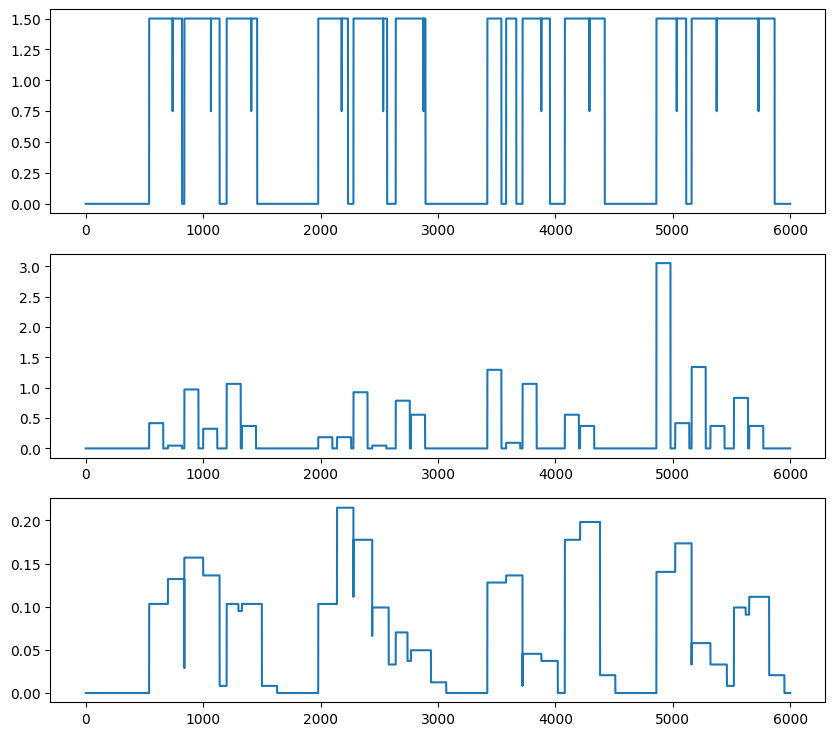

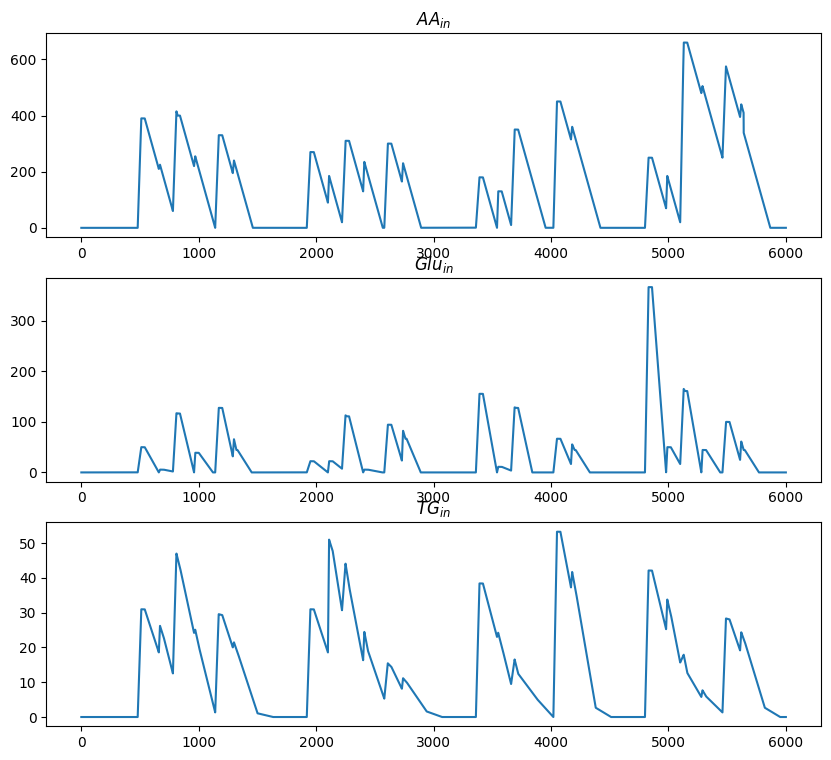

In [10]:
fig,ax = plt.subplots(nrows=3,ncols=1)
fig.set_size_inches(10,9)
ax[0].plot(time_grid,ddt_AA_ef)
ax[1].plot(time_grid,ddt_Glu_ef)
ax[2].plot(time_grid,ddt_TG_pl)
fig2,ax2 = plt.subplots(nrows=3,ncols=1)
fig2.set_size_inches(10,9)
ax2[0].plot(time_grid,J_total_AA_ef)
ax2[0].set_title(r'$AA_{in}$')
ax2[1].plot(time_grid,J_total_Glu_ef)
ax2[1].set_title(r'$Glu_{in}$')
ax2[2].plot(time_grid,J_total_TG_pl)
ax2[2].set_title(r'$TG_{in}$')

In [11]:
torch.save(
    func_on_linear_grid(tau_grid,t_0,t_end, ddt_AA_ef), 
    os.path.join(problem_folder, 'ddt_AA_ef'))
torch.save(
    func_on_linear_grid(tau_grid,t_0,t_end, ddt_Glu_ef), 
    os.path.join(problem_folder, 'ddt_Glu_ef'))
torch.save(
    func_on_linear_grid(tau_grid,t_0,t_end, ddt_TG_pl), 
    os.path.join(problem_folder, 'ddt_TG_pl'))
torch.save(
    func_on_linear_grid(tau_grid,t_0,t_end, J_total_AA_ef), 
    os.path.join(problem_folder, 'J_prot'))
torch.save(
    func_on_linear_grid(tau_grid,t_0,t_end, J_total_Glu_ef), 
    os.path.join(problem_folder, 'J_carb'))
torch.save(
    func_on_linear_grid(tau_grid,t_0,t_end, J_total_TG_pl), 
    os.path.join(problem_folder, 'J_fat'))
